In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Rutas a tus CSV de parámetros por estación
season_files = {
    "Invierno":  "listos/Tabla_parametros_invierno.csv",
    "Primavera": "listos/Tabla_parametros_primavera.csv",
    "Verano":    "listos/Tabla_parametros_verano.csv",
    "Otoño":     "listos/Tabla_parametros_otoño.csv",
}

dfs = []
for season, path in season_files.items():
    df = pd.read_csv(path)
    df["Estacion"] = season   # <-- acá creás la columna Estacion
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)


In [3]:
# Renombrar columnas a algo más manejable
rename_cols = {
    "Temperatura ": "Temperatura",
    "Oxigeno mg/L": "Oxigeno",
    "Conductividad ": "Conductividad",
    "Profundidad m": "Profundidad",
    "Turbidez m": "Turbidez",
    "ph lab": "pH_lab",
    "DBO5 mg O2/L": "DBO5",
    "NO3- mg/L": "NO3",
    "NO2- mg/L": "NO2",
}
df_all = df_all.rename(columns=rename_cols)

In [4]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Nombre         84 non-null     object 
 1   Zona           84 non-null     object 
 2   pH             84 non-null     float64
 3   Temperatura    84 non-null     float64
 4   Oxigeno        84 non-null     float64
 5   Conductividad  84 non-null     int64  
 6   Profundidad    84 non-null     float64
 7   Turbidez       84 non-null     float64
 8   pH_lab         84 non-null     float64
 9   DBO5           84 non-null     int64  
 10  DQO            84 non-null     object 
 11  NO3            84 non-null     float64
 12  NO2            84 non-null     float64
 13  Hora           84 non-null     object 
 14  Fecha          84 non-null     object 
 15  Estacion       84 non-null     object 
dtypes: float64(8), int64(2), object(6)
memory usage: 10.6+ KB


In [5]:
# 2) Definir orden de estaciones
orden_estaciones = ["Invierno", "Primavera", "Verano", "Otoño"]

df = df_all.copy()

# SOLO columnas numéricas
to_numeric = ["pH", "Temperatura", "Oxigeno", "Conductividad", "Profundidad",
              "Turbidez", "pH_lab", "DBO5", "DQO", "NO3", "NO2"]

# 3) Limpiar columnas numéricas (manejar '<0.03')
for col in to_numeric:
    df[col] = (
        df[col].astype(str)
        .str.replace("<", "", regex=False)
        .replace("", pd.NA)
        .astype(float)
    )

# 4) Agrupar por laguna y estación y calcular mean/std
df_stats = (
    df.groupby(["Nombre", "Estacion"])[to_numeric]
    .agg(['mean', 'std'])
    .reset_index()
)

# 5) Aplanar nombres de columnas (pH_mean, pH_std, etc.)
new_cols = []
for col in df_stats.columns:
    if isinstance(col, tuple):
        new_cols.append(f"{col[0]}_{col[1]}")
    else:
        new_cols.append(col)

df_stats.columns = new_cols

# 6) Ordenar estaciones en el orden deseado
df_stats["Estacion_"] = pd.Categorical(
    df_stats["Estacion_"],
    categories=orden_estaciones,
    ordered=True
)

df_stats = df_stats.sort_values(["Nombre_", "Estacion_"])

In [6]:
df_stats.describe()

,pH_mean,pH_std,Temperatura_mean,Temperatura_std,Oxigeno_mean,Oxigeno_std,Conductividad_mean,Conductividad_std,Profundidad_mean,Profundidad_std,...,pH_lab_mean,pH_lab_std,DBO5_mean,DBO5_std,DQO_mean,DQO_std,NO3_mean,NO3_std,NO2_mean,NO2_std
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,...,28.000000,28.0,28.000000,28.0,28.000000,28.0,28.000000,28.0,28.000000,28.0
mean,8.776071,0.210434,20.177500,0.679303,5.176310,0.757911,696.690476,22.507989,0.553333,0.210155,...,9.087857,0.0,2.785714,0.0,82.321429,0.0,1.609286,0.0,0.028007,0.0
std,0.757239,0.329093,7.323841,0.670297,2.816066,0.847444,581.482913,33.483328,0.208976,0.200652,...,1.688529,0.0,4.771498,0.0,72.937342,0.0,1.209982,0.0,0.060499,0.0
min,7.113333,0.000000,10.500000,0.000000,0.600000,0.000000,113.333333,0.000000,0.216667,0.000000,...,6.400000,0.0,0.000000,0.0,0.000000,0.0,0.250000,0.0,0.000000,0.0
25%,8.210000,0.053031,13.475000,0.152753,3.583333,0.370548,210.333333,2.464809,0.378333,0.091892,...,7.577500,0.0,0.000000,0.0,29.750000,0.0,0.894000,0.0,0.000000,0.0
50%,9.010000,0.097697,19.566667,0.437780,4.350000,0.617755,440.333333,10.542491,0.568333,0.166329,...,8.925000,0.0,0.000000,0.0,46.000000,0.0,1.350000,0.0,0.015000,0.0
75%,9.392500,0.180478,26.383333,0.924251,7.658333,0.767008,1238.916667,26.842131,0.684167,0.237126,...,10.575000,0.0,5.000000,0.0,150.500000,0.0,1.946000,0.0,0.015000,0.0
max,9.790000,1.480754,32.336667,2.535744,10.433333,4.561067,1951.666667,165.004040,1.090000,0.874814,...,12.340000,0.0,19.000000,0.0,200.000000,0.0,4.697000,0.0,0.300000,0.0


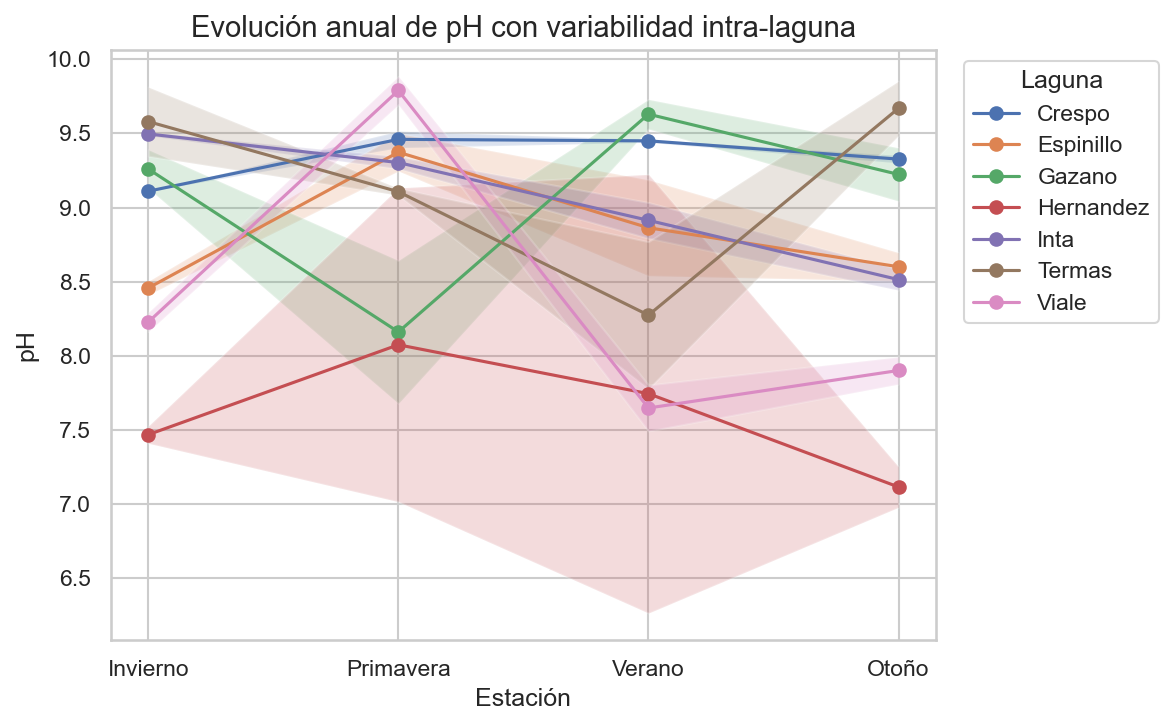

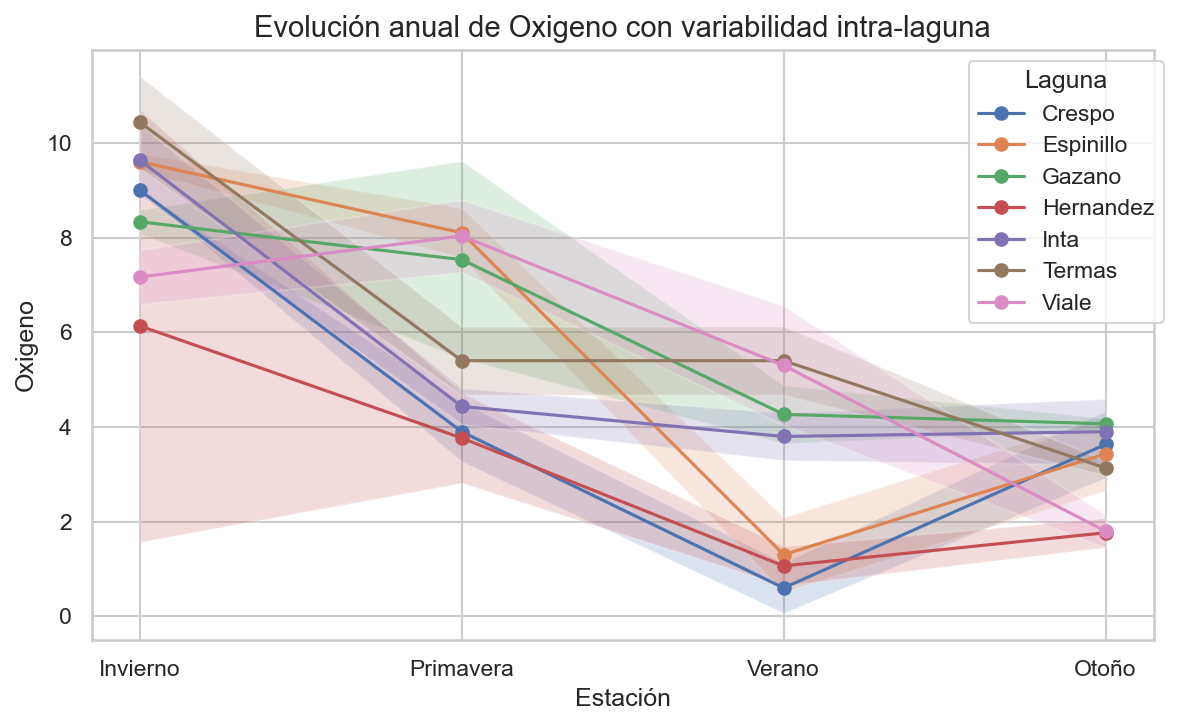

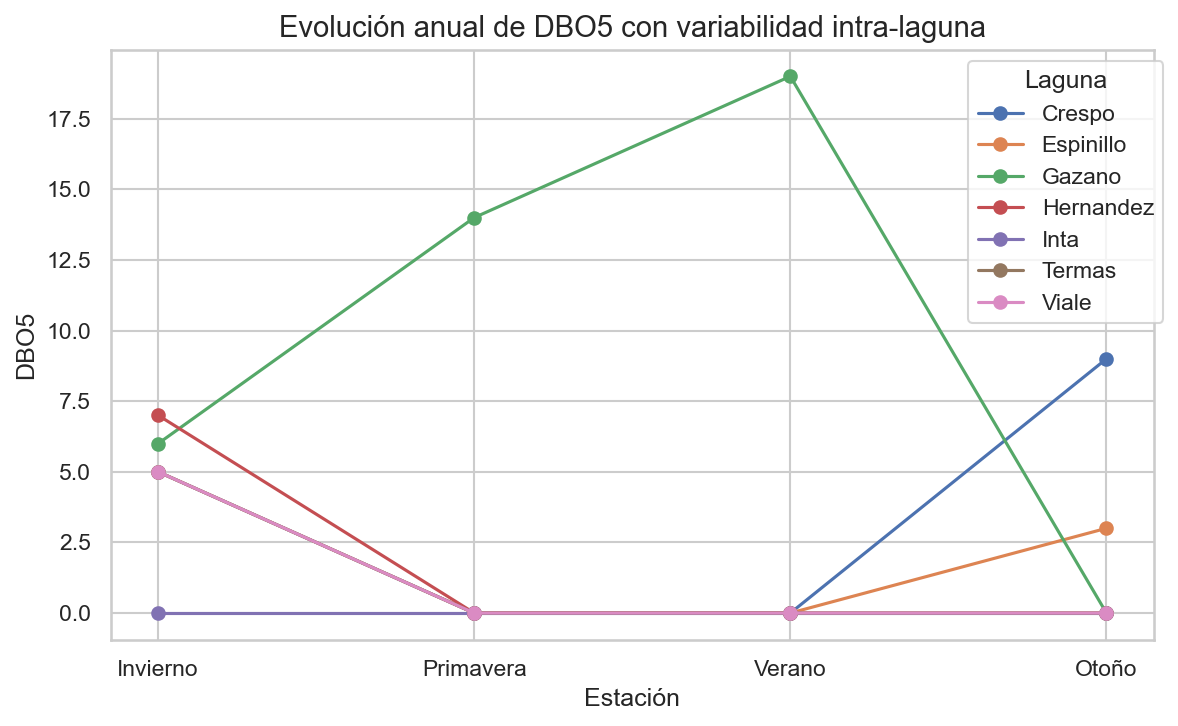

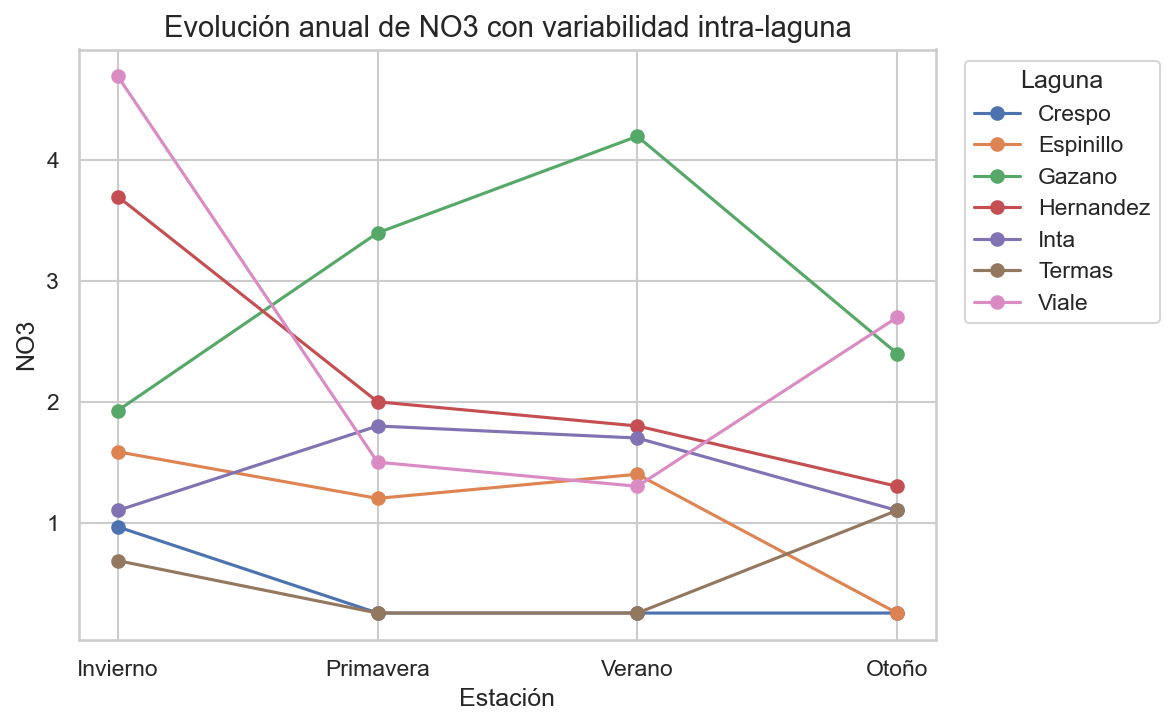

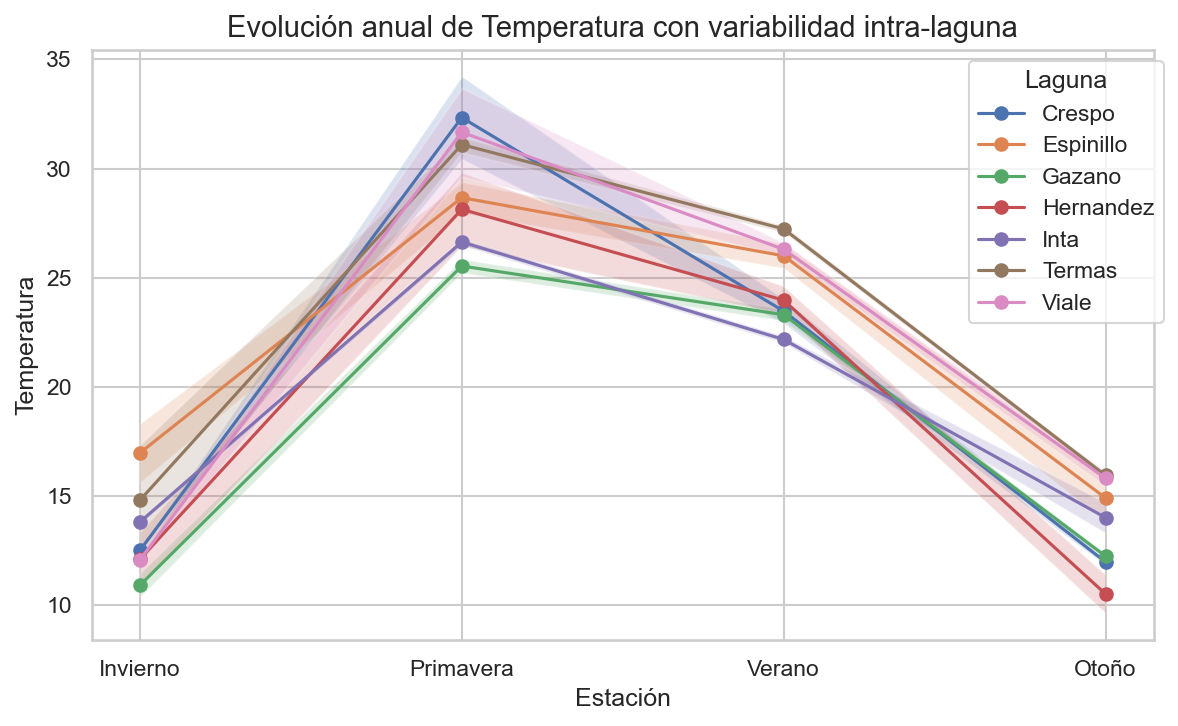

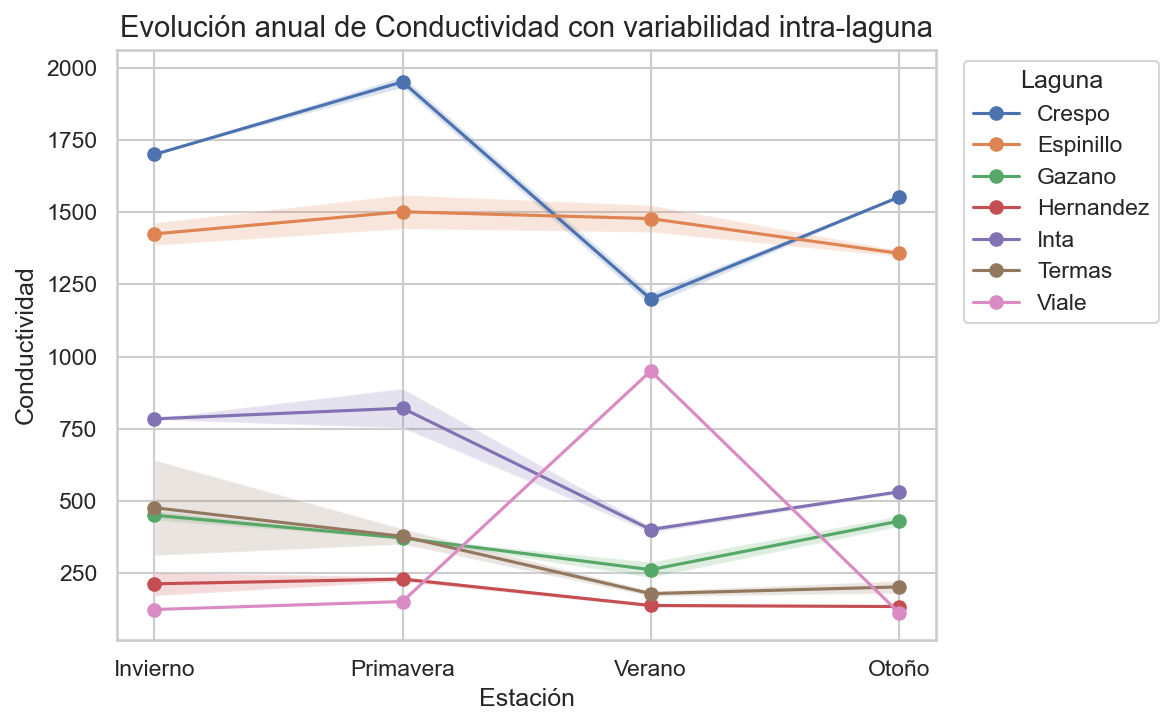

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns



parametros_a_graficar = ["pH", "Oxigeno", "DBO5", "NO3", "Temperatura","Conductividad"]

sns.set(style="whitegrid")

for var in parametros_a_graficar:
    fig, ax = plt.subplots(figsize=(8, 5), dpi=150)

    for lagoon in df_stats["Nombre_"].unique():
        sub = df_stats[df_stats["Nombre_"] == lagoon]

        ax.plot(sub["Estacion_"], sub[f"{var}_mean"], marker="o", label=lagoon)

        # banda del desvío estándar
        ax.fill_between(
            sub["Estacion_"],
            sub[f"{var}_mean"] - sub[f"{var}_std"],
            sub[f"{var}_mean"] + sub[f"{var}_std"],
            alpha=0.2
        )

    ax.set_title(f"Evolución anual de {var} con variabilidad intra-laguna", fontsize=14)
    ax.set_xlabel("Estación")
    ax.set_ylabel(var)
    ax.legend(title="Laguna", bbox_to_anchor=(1.02, 1))
    fig.tight_layout()
    # fig.savefig(f"{var}_evolucion_banda.png")
    plt.show()

